### Decision Tree with Depth 80

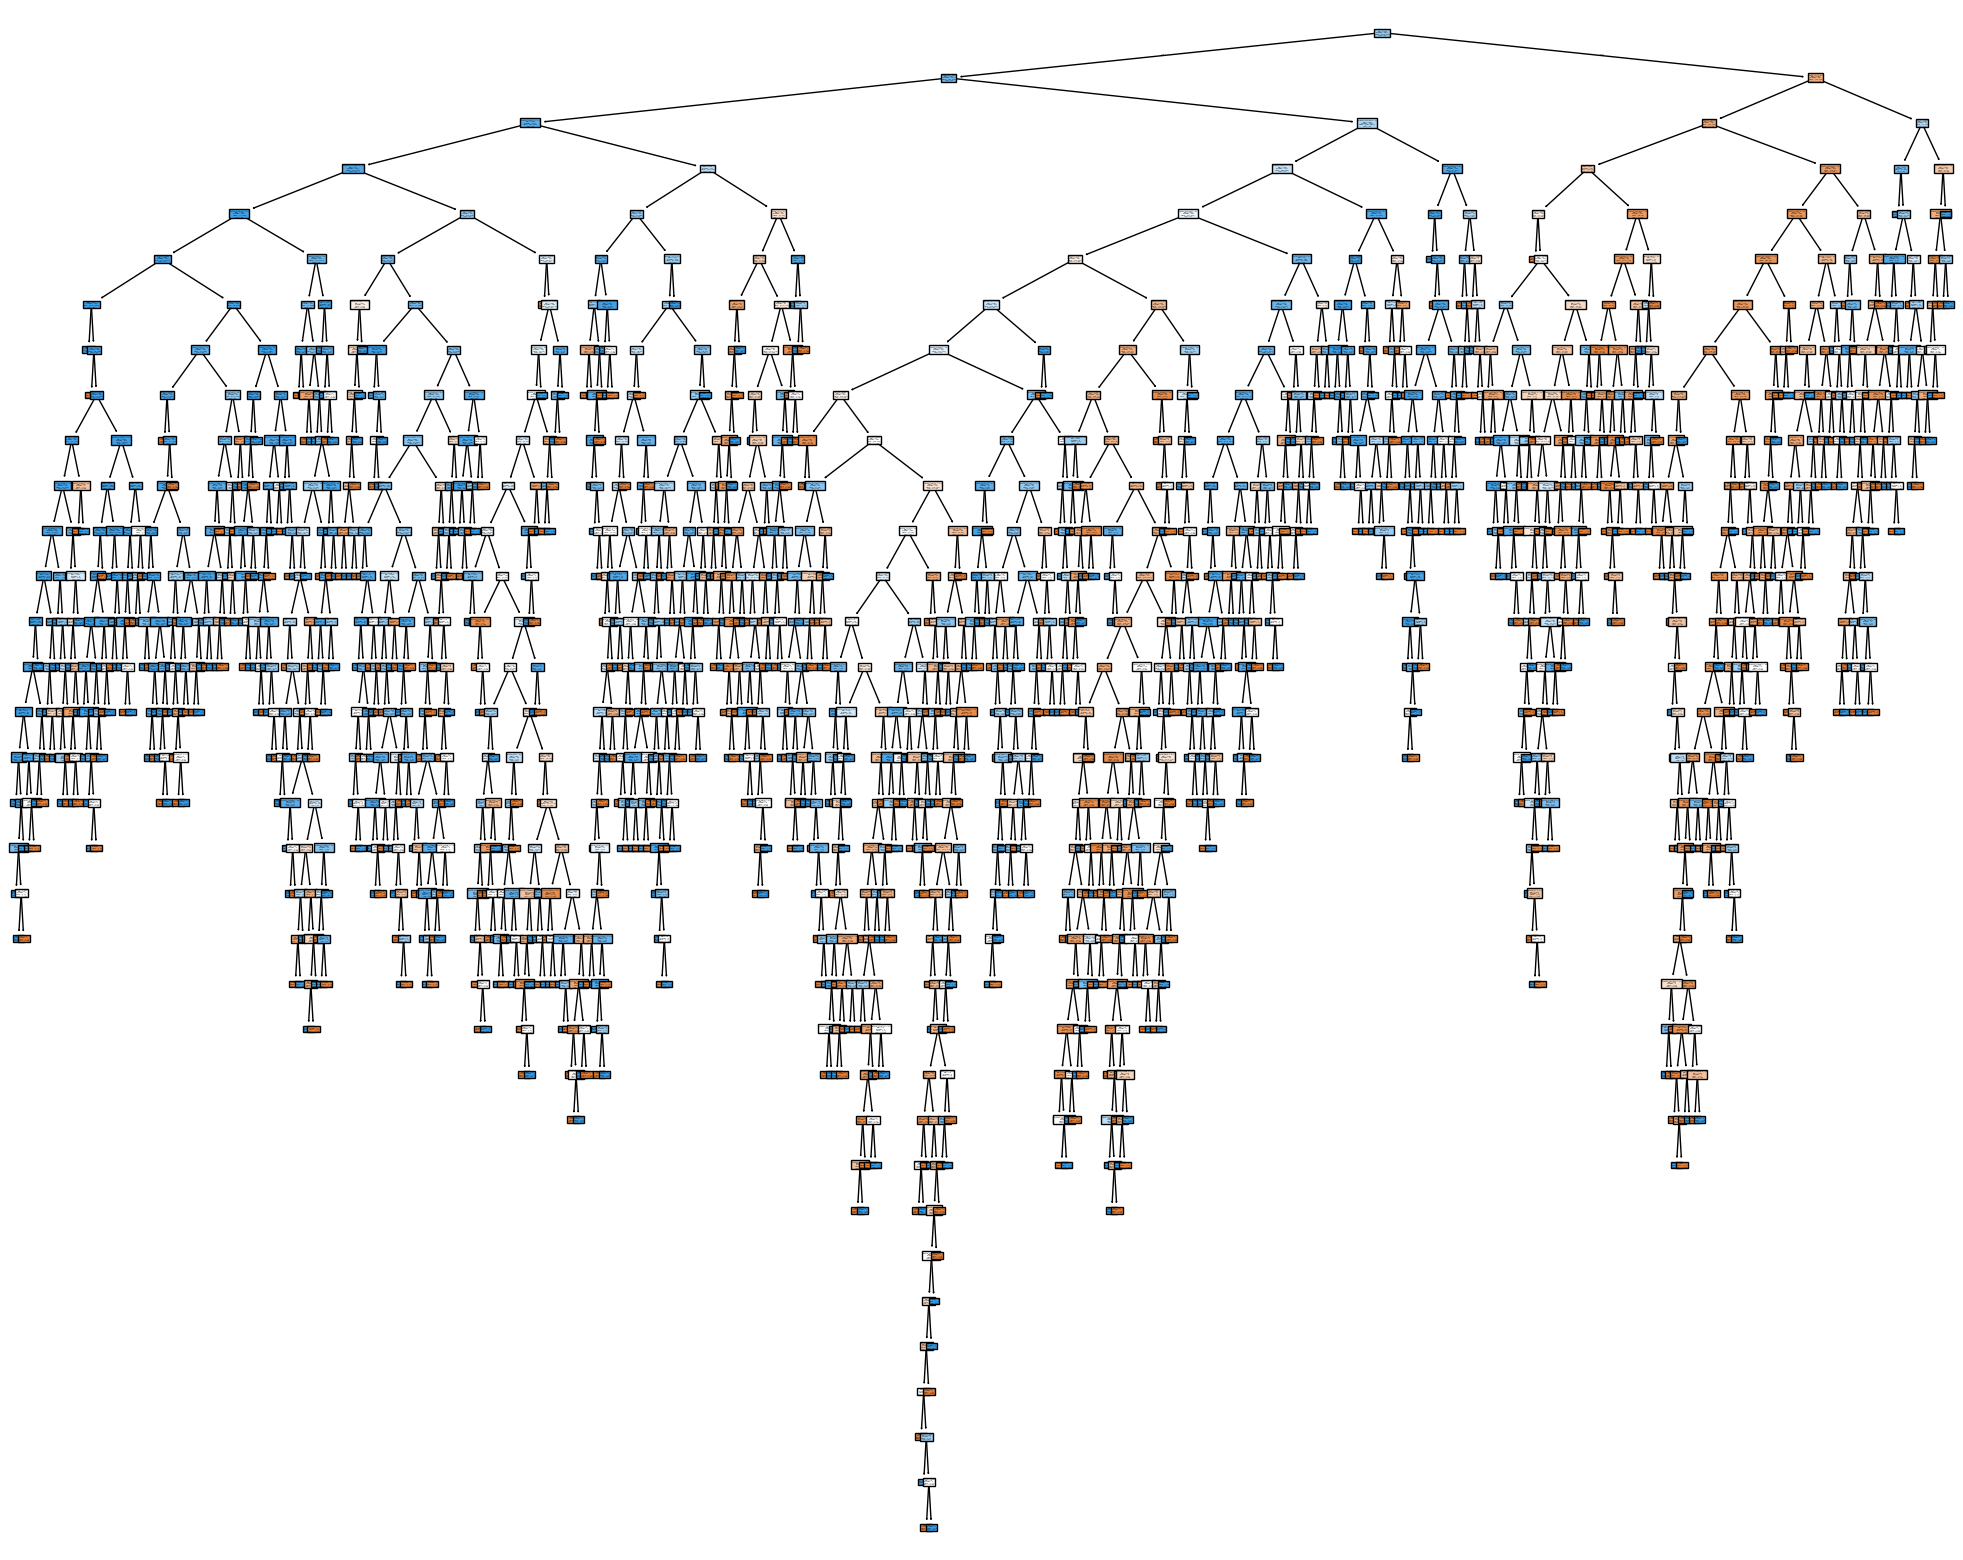

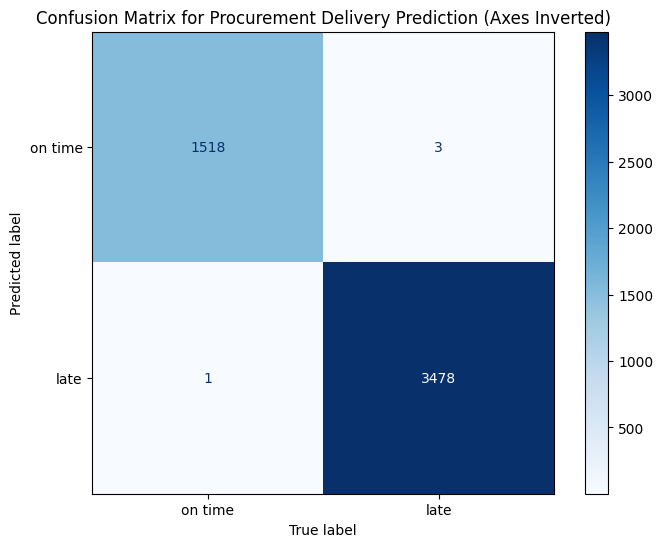

Accuracy: 99.92 %
Precision: 99.97 %
Sensitivity: 99.91 %


In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

# Set the run ID and current date for file naming
runID = 'DT_80_All_Features_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Define the features to be used in the model

features = ['quantity','price'] + [col for col in transactions2.columns if col.startswith('Months_')] + [col for col in transactions2.columns if col.startswith('Weekday_')];

# Train a Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=80)
tree.fit(X = transactions2[features], y = transactions2['late'])

# Make predictions on the training data
plt.figure(figsize=(25,20))
plot_tree(tree, feature_names=features, class_names=['on time','late'], filled=True)
plt.tight_layout
plt.savefig('Decision_Trees/'+runID+'decision_tree_v_'+now_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate the model using confusion matrix
y_pred = tree.predict(transactions2[features])
y_true = transactions2['late']
cm = confusion_matrix(y_true, y_pred)
cm_transposed = cm.T

# Create a confusion matrix display with transposed axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.savefig('Confusion_matrix/'+runID+'confusion_matrix_v_'+now_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

accuracy = accuracy_score(y_true = y_true , y_pred = y_pred)
precision = precision_score(y_true = y_true , y_pred = y_pred)
sensitivity = recall_score(y_true = y_true , y_pred = y_pred)

print (f"Accuracy: {accuracy * 100:.2f} %")
print (f"Precision: {precision * 100:.2f} %")
print (f"Sensitivity: {sensitivity * 100:.2f} %")   

output_text = (
    f"Accuracy: {accuracy * 100:.2f} %\n"
    f"Precision: {precision * 100:.2f} %\n"
    f"Sensitivity: {sensitivity * 100:.2f} %"
)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
plt.text(0.01, 0.5, output_text, fontsize=14, va='center', ha='left')
plt.savefig(f'Performance_Measurement/{runID}metrics_output_{now_str}.png', bbox_inches='tight', dpi=300)
plt.close()


### Decision Tree with Depth 25

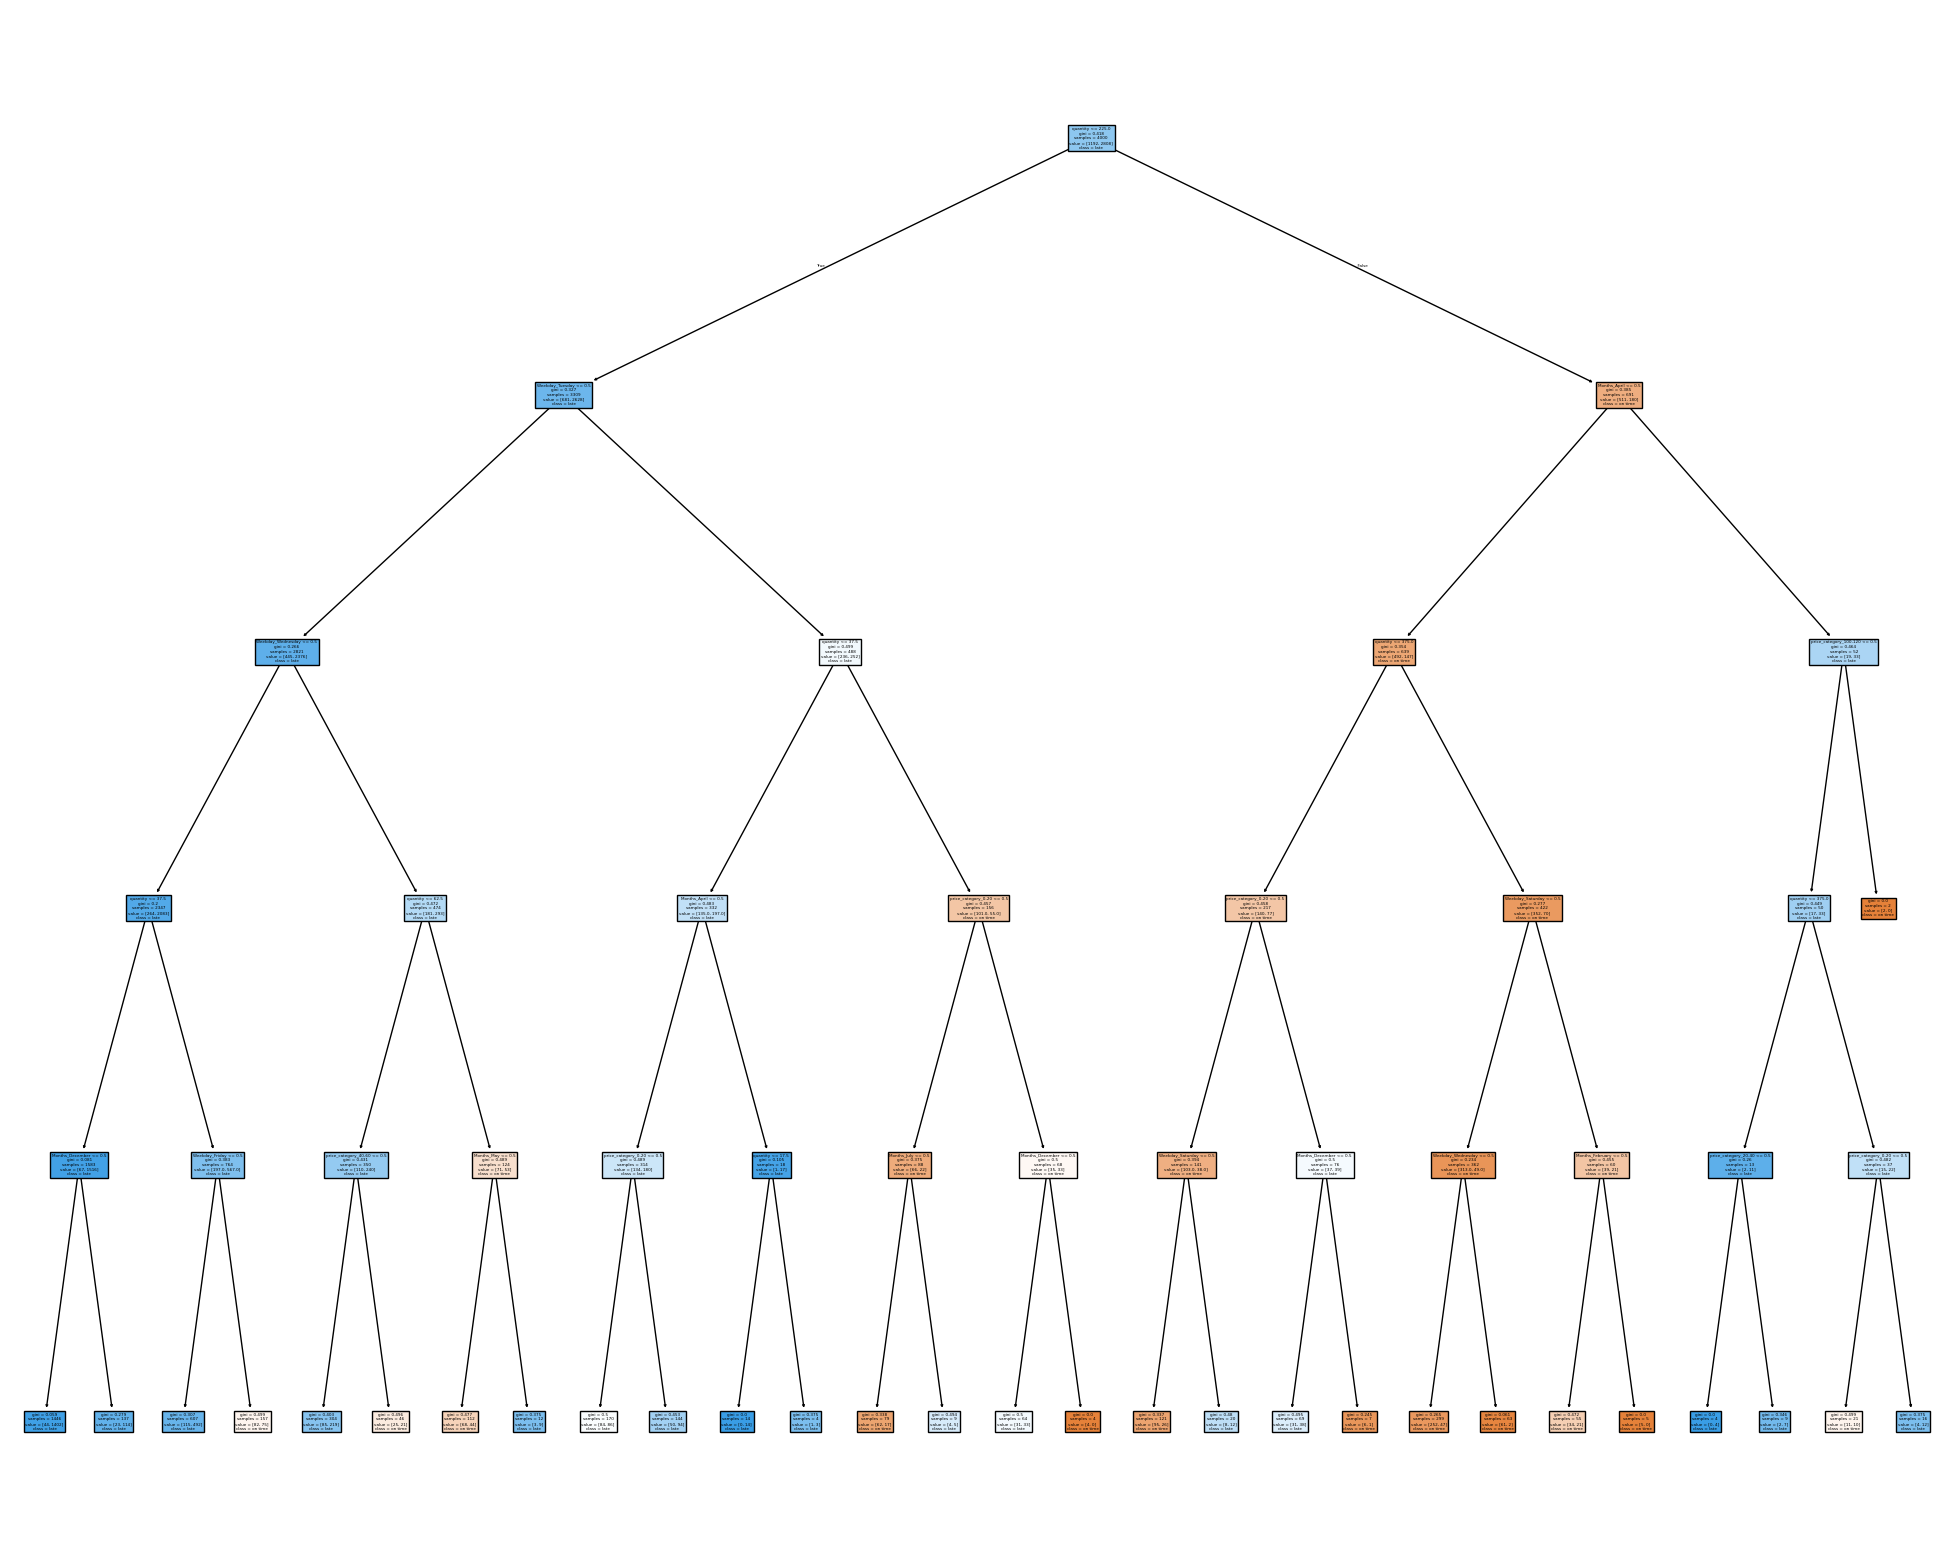

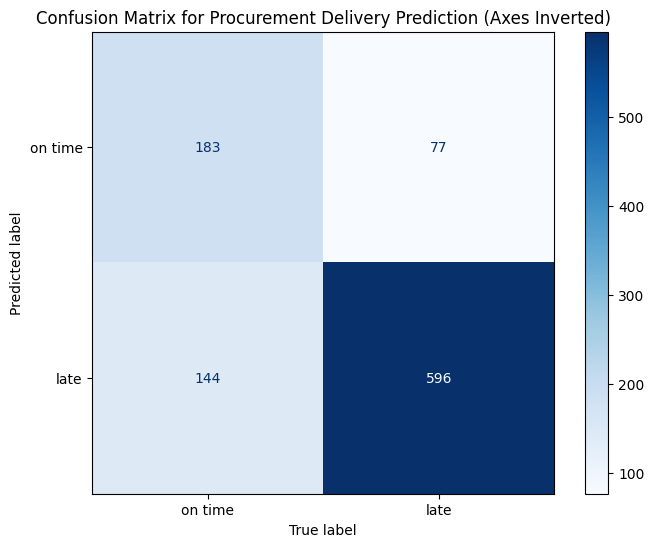

Accuracy: 77.90 %
Precision: 80.54 %
Sensitivity: 88.56 %


In [11]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

# Set the run ID and current date for file naming
maxdepth = 5
runID = 'DT_' + str(maxdepth) + '_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);

depths = list(range(3, 30))
train_accuracies = []
test_accuracies = []
random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)


# Train a Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=maxdepth ,random_state=random_var)
#tree.fit(X = transactions3[features], y = transactions3['late'])
tree.fit(X=X_train, y=y_train)


# Make predictions on the training data
plt.figure(figsize=(25,20))
plot_tree(tree, feature_names=features, class_names=['on time','late'], filled=True)
plt.tight_layout
plt.savefig('Decision_Trees/'+runID+'decision_tree_v_'+now_str+'.png', dpi=300, bbox_inches='tight')

plt.show()

y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)
    
train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
test_acc = accuracy_score(y_true=y_test, y_pred=y_pred)

cm = confusion_matrix(y_test, y_pred)
cm_transposed = cm.T

# Create a confusion matrix display with transposed axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.savefig('Confusion_matrix/'+runID+'confusion_matrix_v_'+now_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

accuracy = accuracy_score(y_true = y_test , y_pred = y_pred)
precision = precision_score(y_true = y_test , y_pred = y_pred)
sensitivity = recall_score(y_true = y_test , y_pred = y_pred)

print (f"Accuracy: {accuracy * 100:.2f} %")
print (f"Precision: {precision * 100:.2f} %")
print (f"Sensitivity: {sensitivity * 100:.2f} %")   

output_text = (
    f"Accuracy: {accuracy * 100:.2f} %\n"
    f"Precision: {precision * 100:.2f} %\n"
    f"Sensitivity: {sensitivity * 100:.2f} %"
)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
plt.text(0.01, 0.5, output_text, fontsize=14, va='center', ha='left')
plt.savefig(f'Performance_Measurement/{runID}metrics_output_{now_str}.png', bbox_inches='tight', dpi=300)
plt.close()


### Random Forest  with Depth 25

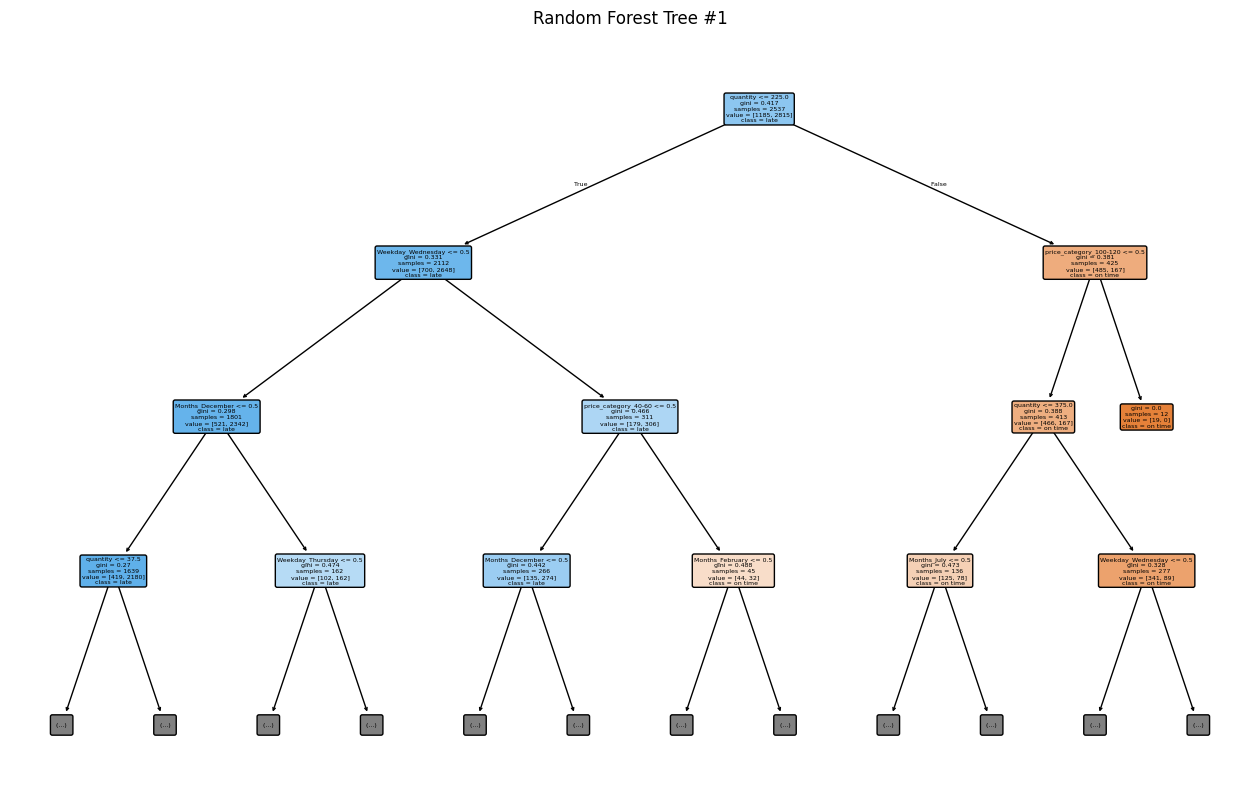

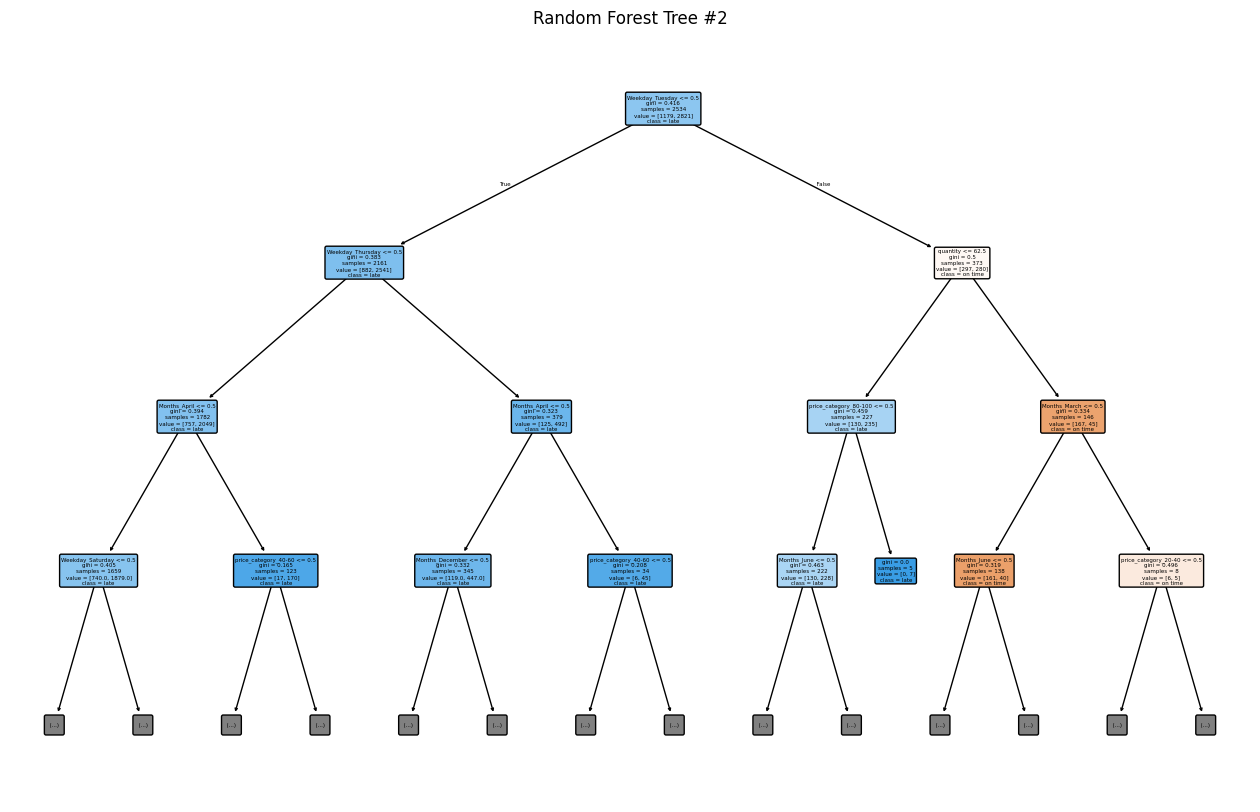

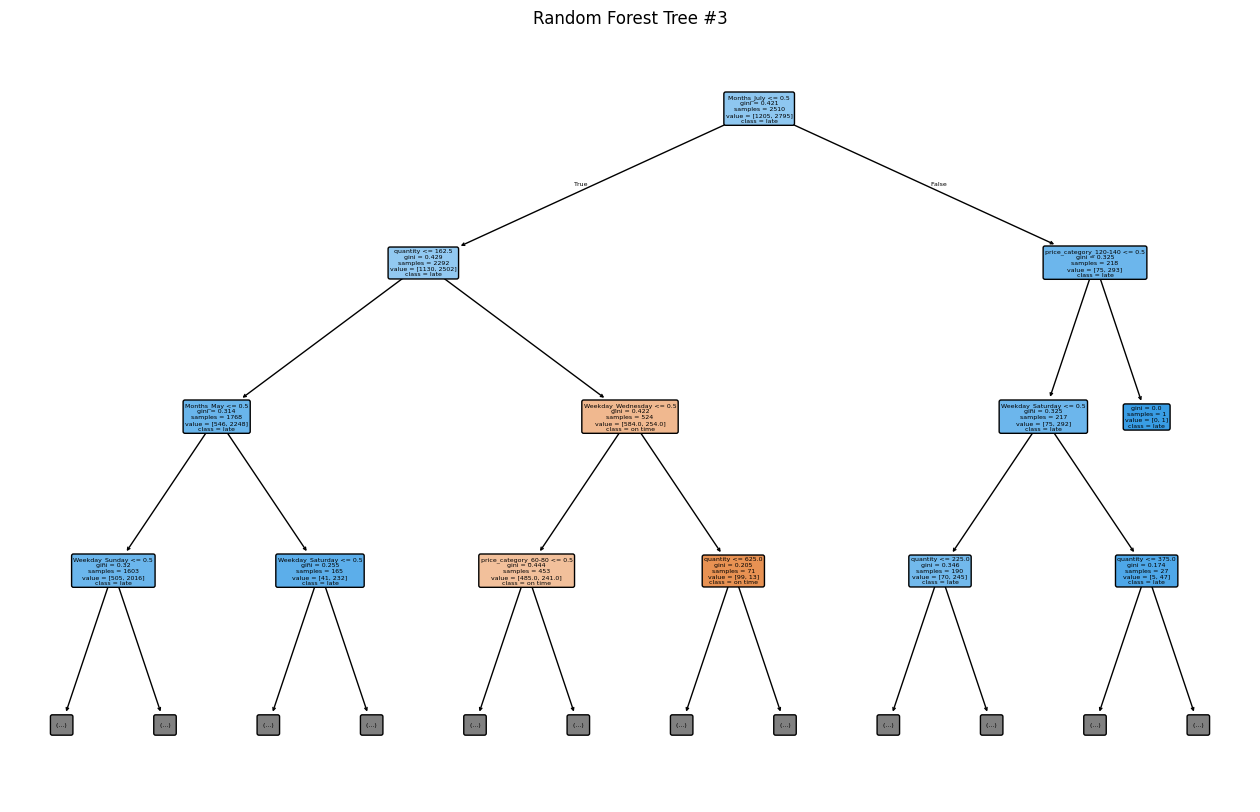

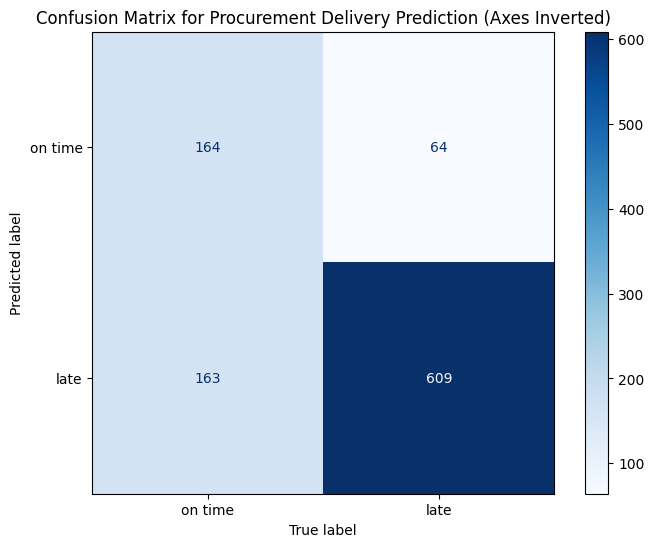

Accuracy: 77.30 %
Precision: 78.89 %
Sensitivity: 90.49 %


In [12]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

# Set the run ID and current date for file naming
maxdepth = 12
runID = 'RF_'+str(maxdepth) +'_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);


random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)

# Train a Random Forest Classifier with depth of 25
rf = RandomForestClassifier(n_estimators=100, max_depth=maxdepth)
rf.fit(X=X_train, y=y_train)

# Plot the first 3 trees in the random forest

for i in range(3):
    plt.figure(figsize=(16, 10))
    plot_tree(
        rf.estimators_[i],
        feature_names=features,
        class_names=['on time', 'late'],
        filled=True,
        rounded=True,
        max_depth=3  # Optional: limit depth for readability
    )
    plt.title(f"Random Forest Tree #{i+1}")
    plt.show()


# Make predictions on the training data

# Evaluate the model using confusion matrix



rf_pred = rf.predict(X_test)
y_pred_train= rf.predict(X_train)

train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
test_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)

cm = confusion_matrix(y_test, rf_pred)
cm_transposed = cm.T

# Create a confusion matrix display with transposed axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.savefig('Confusion_matrix/'+runID+'confusion_matrix_v_'+now_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

accuracy = accuracy_score(y_true = y_test , y_pred = rf_pred)
precision = precision_score(y_true = y_test , y_pred = rf_pred)
sensitivity = recall_score(y_true = y_test , y_pred = rf_pred)

print (f"Accuracy: {accuracy * 100:.2f} %")
print (f"Precision: {precision * 100:.2f} %")
print (f"Sensitivity: {sensitivity * 100:.2f} %")   

output_text = (
    f"Accuracy: {accuracy * 100:.2f} %\n"
    f"Precision: {precision * 100:.2f} %\n"
    f"Sensitivity: {sensitivity * 100:.2f} %"
)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
plt.text(0.01, 0.5, output_text, fontsize=14, va='center', ha='left')
plt.savefig(f'Performance_Measurement/{runID}metrics_output_{now_str}.png', bbox_inches='tight', dpi=300)
plt.close()


### Gradiant Boost with Depth 25

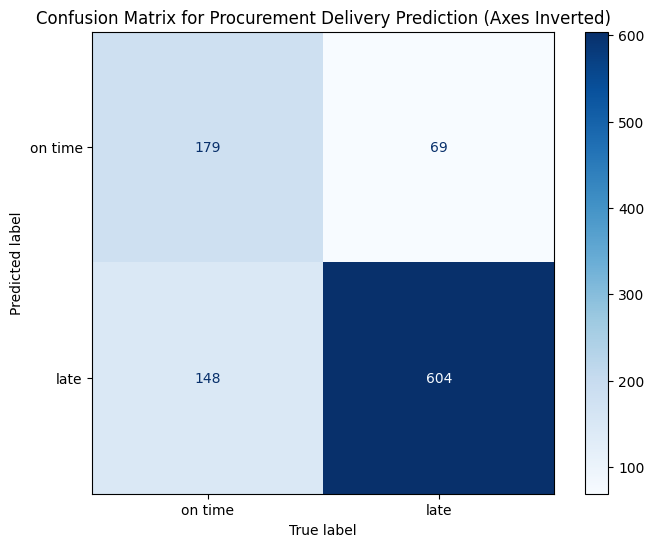

Accuracy: 78.30 %
Precision: 80.32 %
Sensitivity: 89.75 %


In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

# Set the run ID and current date for file naming
maxdepth = 3
runID = 'GB_'+str(maxdepth) +'_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);

# Train a Gradiant booster Classifier with depth of 25

random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)

gbm = GradientBoostingClassifier(max_depth=maxdepth, n_estimators=100, random_state=random_var)
gbm.fit(X=X_train, y=y_train)

# Make predictions on the training data
gbm_pred = gbm.predict(X_test)
y_pred_train = gbm.predict(X_train)
    
train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
test_acc = accuracy_score(y_true=y_test, y_pred=gbm_pred)

cm = confusion_matrix(y_test, gbm_pred)
cm_transposed = cm.T

# Create a confusion matrix display with transposed axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, 
                             display_labels=['on time', 'late'])

# Create a figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.xlabel('True label')  # This will now be on the x-axis
plt.ylabel('Predicted label')  # This will now be on the y-axis
plt.title('Confusion Matrix for Procurement Delivery Prediction (Axes Inverted)')
plt.savefig('Confusion_matrix/'+runID+'confusion_matrix_v_'+now_str+'.png', dpi=300, bbox_inches='tight')
plt.show()

accuracy = accuracy_score(y_true = y_test , y_pred = gbm_pred)
precision = precision_score(y_true = y_test , y_pred = gbm_pred)
sensitivity = recall_score(y_true = y_test , y_pred = gbm_pred)


print (f"Accuracy: {accuracy * 100:.2f} %")
print (f"Precision: {precision * 100:.2f} %")
print (f"Sensitivity: {sensitivity * 100:.2f} %")   

output_text = (
    f"Accuracy: {accuracy * 100:.2f} %\n"
    f"Precision: {precision * 100:.2f} %\n"
    f"Sensitivity: {sensitivity * 100:.2f} %"
)

# Create a figure
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Hide axes
plt.text(0.01, 0.5, output_text, fontsize=14, va='center', ha='left')
plt.savefig(f'Performance_Measurement/{runID}metrics_output_{now_str}.png', bbox_inches='tight', dpi=300)
plt.close()


### Depth Accuracy Comparison Decision Tree

Max depth: 3, Test accuracy: 0.76, Train accuracy: 0.80
Max depth: 4, Test accuracy: 0.77, Train accuracy: 0.81
Max depth: 5, Test accuracy: 0.78, Train accuracy: 0.81
Max depth: 6, Test accuracy: 0.78, Train accuracy: 0.82
Max depth: 7, Test accuracy: 0.78, Train accuracy: 0.83
Max depth: 8, Test accuracy: 0.77, Train accuracy: 0.84
Max depth: 9, Test accuracy: 0.77, Train accuracy: 0.85
Max depth: 10, Test accuracy: 0.76, Train accuracy: 0.87
Max depth: 11, Test accuracy: 0.74, Train accuracy: 0.88
Max depth: 12, Test accuracy: 0.75, Train accuracy: 0.89
Max depth: 13, Test accuracy: 0.75, Train accuracy: 0.90
Max depth: 14, Test accuracy: 0.75, Train accuracy: 0.91
Max depth: 15, Test accuracy: 0.75, Train accuracy: 0.91
Max depth: 16, Test accuracy: 0.74, Train accuracy: 0.92
Max depth: 17, Test accuracy: 0.74, Train accuracy: 0.92
Max depth: 18, Test accuracy: 0.73, Train accuracy: 0.92
Max depth: 19, Test accuracy: 0.73, Train accuracy: 0.93
Max depth: 20, Test accuracy: 0.73, Tr

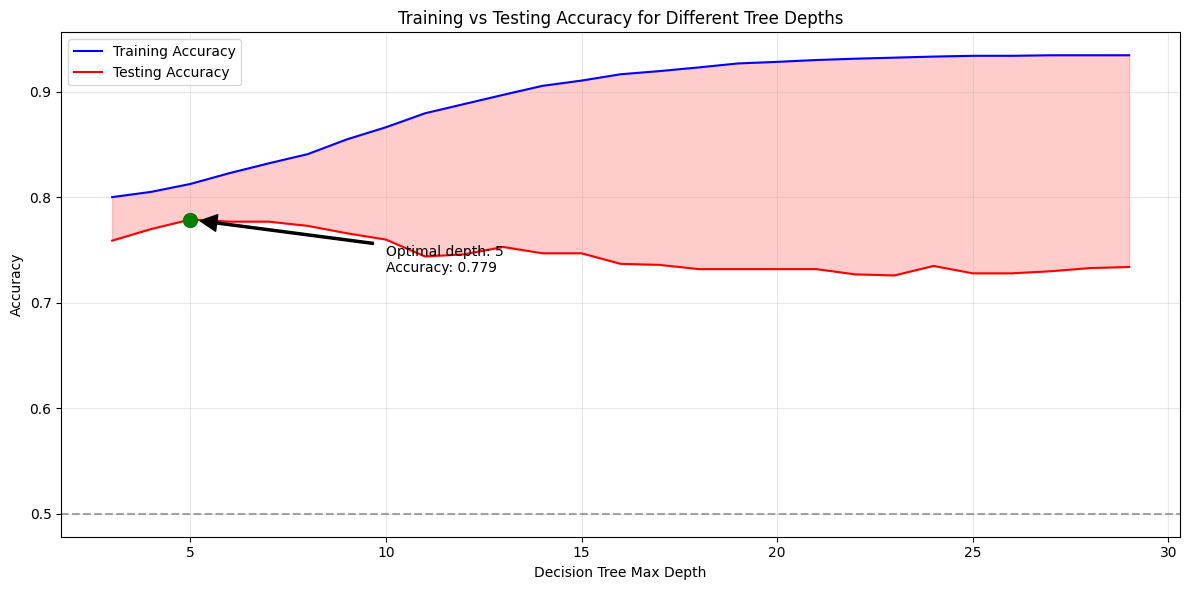

In [14]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

maxdepth = 25
runID = 'DT_' + str(maxdepth) + '_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

# features = (['quantity'] + 
# [col for col in transactions3.columns if col.startswith('Months_')] + 
# [col for col in transactions3.columns if col.startswith('Weekday_')] +
# [col for col in transactions3.columns if col.startswith('price_category_')]);

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);




depths = list(range(3, 30))
train_accuracies = []
test_accuracies = []
random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)

for i in range(3, 30):
    tree_overfitted = DecisionTreeClassifier(max_depth=i, random_state=random_var)
    tree_overfitted.fit(X=X_train, y=y_train)
    
    y_pred_test = tree_overfitted.predict(X_test)
    y_pred_train = tree_overfitted.predict(X_train)
    
    print(f"Max depth: {i}, Test accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_test):.2f}, Train accuracy: {accuracy_score(y_true=y_train, y_pred=y_pred_train):.2f}")


# Loop over different max depths
for i in depths:
    tree_model = DecisionTreeClassifier(max_depth=i, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(depths, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_depth_index = np.argmax(test_accuracies)
optimal_depth = depths[optimal_depth_index]
optimal_accuracy = test_accuracies[optimal_depth_index]

plt.scatter(optimal_depth, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal depth: {optimal_depth}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_depth, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(depths, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig(f'Performance_Measurement/DT_depth_accuracy_comparison_{now_str}.png', dpi=300)
plt.show()

### Depth Accuracy Comparison Random Forest

Max depth: 3, Test accuracy: 0.71, Train accuracy: 0.74
Max depth: 4, Test accuracy: 0.73, Train accuracy: 0.77
Max depth: 5, Test accuracy: 0.74, Train accuracy: 0.79
Max depth: 6, Test accuracy: 0.76, Train accuracy: 0.81
Max depth: 7, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 8, Test accuracy: 0.76, Train accuracy: 0.83
Max depth: 9, Test accuracy: 0.76, Train accuracy: 0.85
Max depth: 10, Test accuracy: 0.76, Train accuracy: 0.86
Max depth: 11, Test accuracy: 0.77, Train accuracy: 0.87
Max depth: 12, Test accuracy: 0.78, Train accuracy: 0.89
Max depth: 13, Test accuracy: 0.78, Train accuracy: 0.90
Max depth: 14, Test accuracy: 0.78, Train accuracy: 0.90
Max depth: 15, Test accuracy: 0.77, Train accuracy: 0.91
Max depth: 16, Test accuracy: 0.77, Train accuracy: 0.92
Max depth: 17, Test accuracy: 0.76, Train accuracy: 0.92
Max depth: 18, Test accuracy: 0.77, Train accuracy: 0.93
Max depth: 19, Test accuracy: 0.76, Train accuracy: 0.93
Max depth: 20, Test accuracy: 0.75, Tr

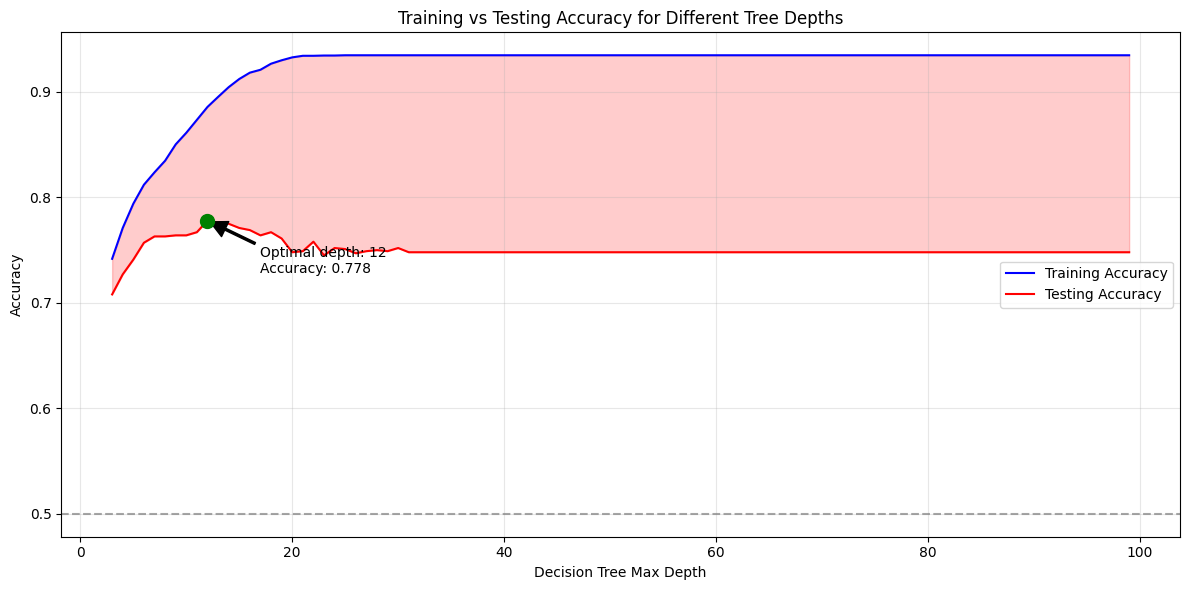

In [17]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

maxdepth = 25
runID = 'RF_' + str(maxdepth) + '_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

# features = (['quantity'] + 
# [col for col in transactions3.columns if col.startswith('Months_')] + 
# [col for col in transactions3.columns if col.startswith('Weekday_')] +
# [col for col in transactions3.columns if col.startswith('price_category_')]);

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);




depths = list(range(3, 100))
train_accuracies = []
test_accuracies = []
random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)

for i in range(3, 30):
    rf_overfitted = RandomForestClassifier(n_estimators=100, max_depth= i, random_state=random_var)
    rf_overfitted.fit(X=X_train, y=y_train)
    
    y_pred_test = rf_overfitted.predict(X_test)
    y_pred_train = rf_overfitted.predict(X_train)
    
    print(f"Max depth: {i}, Test accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_test):.2f}, Train accuracy: {accuracy_score(y_true=y_train, y_pred=y_pred_train):.2f}")


# Loop over different max depths
for i in depths:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth= i, random_state=random_var)
    rf_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(depths, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_depth_index = np.argmax(test_accuracies)
optimal_depth = depths[optimal_depth_index]
optimal_accuracy = test_accuracies[optimal_depth_index]

plt.scatter(optimal_depth, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal depth: {optimal_depth}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_depth, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(depths, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig(f'Performance_Measurement/RF_depth_accuracy_comparison_{now_str}.png', dpi=300)
plt.show()

### Depth Accuracy Comparison for Gradient Boosting Classifier

Max depth: 3, Test accuracy: 0.67, Train accuracy: 0.70
Max depth: 4, Test accuracy: 0.68, Train accuracy: 0.72
Max depth: 5, Test accuracy: 0.73, Train accuracy: 0.78
Max depth: 6, Test accuracy: 0.74, Train accuracy: 0.80
Max depth: 7, Test accuracy: 0.75, Train accuracy: 0.80
Max depth: 8, Test accuracy: 0.75, Train accuracy: 0.81
Max depth: 9, Test accuracy: 0.75, Train accuracy: 0.81
Max depth: 10, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 11, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 12, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 13, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 14, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 15, Test accuracy: 0.76, Train accuracy: 0.82
Max depth: 16, Test accuracy: 0.77, Train accuracy: 0.83
Max depth: 17, Test accuracy: 0.77, Train accuracy: 0.83
Max depth: 18, Test accuracy: 0.78, Train accuracy: 0.83
Max depth: 19, Test accuracy: 0.78, Train accuracy: 0.83
Max depth: 20, Test accuracy: 0.78, Tr

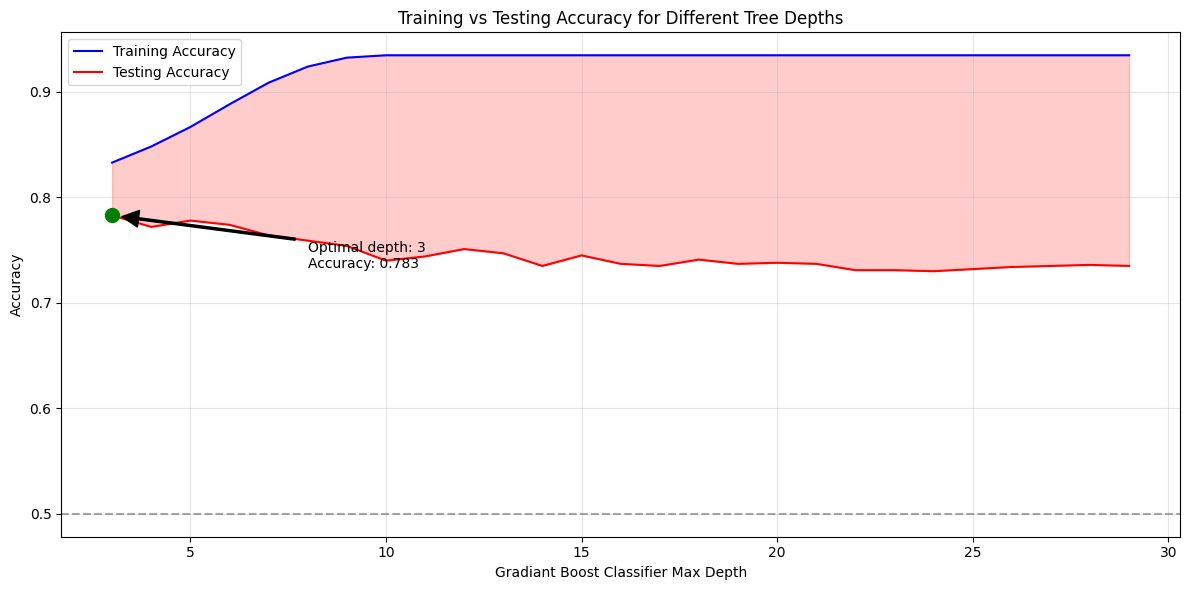

In [16]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , precision_score , recall_score
import os
from datetime import datetime

maxdepth = 25
runID = 'GBC_' + str(maxdepth) + '_Price_Catagorized_'
now_str = datetime.now().strftime("%Y%m%d")

# Load the datasets
customer = pd.read_excel('Data/customer.xlsx');
logistic_partners = pd.read_excel('Data/logistic_partner.xlsx');
transactions = pd.read_excel('Data/sales_transactions_star_schema.xlsx');
materials = pd.read_excel('Data/material.xlsx');
warehouse = pd.read_excel('Data/warehouse.xlsx');

# Convert date columns to datetime.date format
transactions["requested_date"]= pd.to_datetime(transactions["requested_date"]).dt.date;
transactions["received_date"]= pd.to_datetime(transactions["received_date"]).dt.date;

# Create a new column to indicate if the transaction is late
transactions["late"]= transactions["requested_date"] < pd.to_datetime(transactions["received_date"])

# Extract weekday and month names from the date columns
transactions["Weekday"] = pd.to_datetime(transactions["requested_date"]).dt.day_name()
transactions["Months"] = pd.to_datetime(transactions["received_date"]).dt.month_name()

# Convert categorical variables to dummy variables
transactions2 = pd.get_dummies(transactions, columns=['Weekday'])
transactions2 = pd.get_dummies(transactions2, columns=['Months'])

# Create price categories
# Define bins and labels for price categories   

bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
labels = [
        '0-20', '20-40', '40-60', '60-80', '80-100',
        '100-120', '120-140', '140-160', '160-180', '180-200', '200-220'
    ]
transactions2['price_category'] = pd.cut(transactions2['price'], bins=bins, labels=labels, right=False)

# Convert price categories to dummy variables
transactions3 = pd.get_dummies(transactions2, columns=['price_category'])

# Define the features to be used in the model

# features = (['quantity'] + 
# [col for col in transactions3.columns if col.startswith('Months_')] + 
# [col for col in transactions3.columns if col.startswith('Weekday_')] +
# [col for col in transactions3.columns if col.startswith('price_category_')]);

features = (['quantity'] + 
[col for col in transactions3.columns if col.startswith('Months_')] + 
[col for col in transactions3.columns if col.startswith('Weekday_')] +
[col for col in transactions3.columns if col.startswith('price_category_')]);

depths = list(range(3, 30))
train_accuracies = []
test_accuracies = []
random_var = 2025

X_train, X_test, y_train, y_test = train_test_split(
    transactions3[features], 
    transactions3['late'],
    test_size=0.2, 
    random_state=random_var
)

for i in range(3, 30):
    tree_model = GradientBoostingClassifier(max_depth=5, n_estimators=i, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    print(f"Max depth: {i}, Test accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred_test):.2f}, Train accuracy: {accuracy_score(y_true=y_train, y_pred=y_pred_train):.2f}")


# Loop over different max depths
for i in depths:
    tree_model = GradientBoostingClassifier(max_depth=i, n_estimators=100, random_state=random_var)
    tree_model.fit(X=X_train, y=y_train)
    
    # Predict and calculate accuracy
    y_pred_test = tree_model.predict(X_test)
    y_pred_train = tree_model.predict(X_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(depths, test_accuracies, label='Testing Accuracy', color='red')
plt.xlabel('Gradiant Boost Classifier Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)

# Add a horizontal line showing baseline performance
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Baseline (50%)')

# Add annotation for optimal depth
optimal_depth_index = np.argmax(test_accuracies)
optimal_depth = depths[optimal_depth_index]
optimal_accuracy = test_accuracies[optimal_depth_index]

plt.scatter(optimal_depth, optimal_accuracy, color='green', s=100, zorder=5)
plt.annotate(f'Optimal depth: {optimal_depth}\nAccuracy: {optimal_accuracy:.3f}', 
             xy=(optimal_depth, optimal_accuracy),
             xytext=(optimal_depth+5, optimal_accuracy-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Shade the overfitting region
plt.fill_between(depths, train_accuracies, test_accuracies, 
                 where=(np.array(train_accuracies) > np.array(test_accuracies)), 
                 color='red', alpha=0.2, label='Overfitting region')

plt.tight_layout()
plt.savefig(f'Performance_Measurement/GBC_depth_accuracy_comparison_{now_str}.png', dpi=300)
plt.show()